In [23]:
import re
import json
import pysam
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
import pyBigWig
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

# Benchmark of SV for HG001

## Benchmark regions

In [15]:
! ls -lh ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/*

-rw-r--r-- 1 chenzg tfclab  53K Apr 10 01:24 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.coverage_lt_10_gt_80.bed
-rw-r--r-- 1 chenzg tfclab 299K Apr 10 01:26 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.coverage_lt_15_gt_80.bed
-rw-r--r-- 1 chenzg tfclab  34K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.dense_sv_1kb.bed
-rw-r--r-- 1 chenzg tfclab 1.9K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.long_sv_10kb_slop_1kb.bed
-rw-r--r-- 1 chenzg tfclab  36K Apr 10 01:27 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/Ultralong.full.coverage_lt_10_gt_80.bed
-rw-r--r-- 1 chenzg tfclab  57K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/Ultralong.full.coverage_lt_15_gt_80.bed
-rw-r--r-- 1 chenzg tfclab  49K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/Ultralong.full.dense_sv_1kb.bed
-rw-r--r-- 1 chenzg tfclab 2.8K Apr 10 01:29 ../../3_NanoStrandSeq_P

## Length of SVs

In [16]:
def load_svs(f_vcf, f_tsv, f_bed=None):
    d = pd.read_csv(f_tsv, sep="\t")
    d = d[d["AgreeRead"] >= 5]
    if "NSS" in f_vcf:
        d = d[d["AgreeCell"] >= 3]
    d = d[(d["AgreeRead"] / (d["AgreeRead"] + d["DisagreeRead"])) >= 0.1]
    pass_names = set(d["Name"])

    svs = []
    with pysam.VariantFile(f_vcf) as f:
        for record in f:
            svtype = record.info["SVTYPE"]
            if svtype != "DEL" and svtype != "INS":
                continue
            if list(record.filter)[0] != "PASS":
                continue
            if record.id not in pass_names:
                continue
            sv = GRange(chrom=record.contig, start=record.start, end=record.stop, name=record.id)
            sv.length = abs(record.info["SVLEN"])
            svs.append(sv)
    svs.sort()
    
    if f_bed is not None:
        with BedFile(f_bed) as f:
            regions = [x for x in f]
            regions.sort()
            svs = filter_blacklist_svs(svs, regions)
            
    return svs
    
f_vcf = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz"
f_tsv = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/quantify_merged_lite.tsv"  
svs = load_svs(f_vcf, f_tsv)
vs1 = [sv.length for sv in filter(lambda sv: "DEL" in sv.name, svs)]
vs2 = [sv.length for sv in filter(lambda sv: "INS" in sv.name, svs)]

[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz.tbi


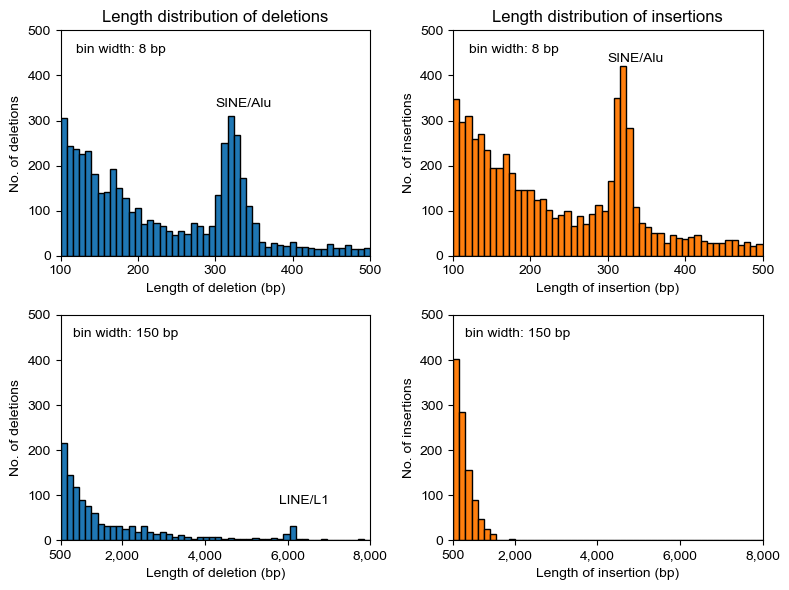

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

ax = axs[0][0]
plt.sca(ax)
plt.hist(vs1, range=(100, 500), bins=50, edgecolor="black", color="C0")
plt.title("Length distribution of deletions")
plt.xlabel("Length of deletion (bp)")
plt.ylabel("No. of deletions")
plt.xlim(100, 500)
plt.ylim(0, 500)
plt.text(300, 330, "SINE/Alu")
plt.text(120, 450, "bin width: 8 bp")

ax = axs[1][0]
plt.sca(ax)
plt.hist(vs1, range=(500, 8000), bins=50, edgecolor="black", color="C0")
plt.xlabel("Length of deletion (bp)")
plt.ylabel("No. of deletions")
plt.ylim(0, 500)
plt.xlim(500, 8000)
plt.text(5800, 80, "LINE/L1")
xs = [500, 2000, 4000, 6000, 8000]
plt.xticks(xs, [format(x, ",") for x in xs])
plt.text(800, 450, "bin width: 150 bp")

ax = axs[0][1]
plt.sca(ax)
plt.hist(vs2, range=(100, 500), bins=50, edgecolor="black", color="C1")
plt.title("Length distribution of insertions")
plt.xlabel("Length of insertion (bp)")
plt.ylabel("No. of insertions")
plt.xlim(100, 500)
plt.ylim(0, 500)
plt.text(300, 430, "SINE/Alu")
plt.text(120, 450, "bin width: 8 bp")

ax = axs[1][1]
plt.sca(ax)
plt.hist(vs2, range=(500, 8000), bins=50, edgecolor="black", color="C1")
plt.xlabel("Length of insertion (bp)")
plt.ylabel("No. of insertions")
plt.xlim(500, 8000)
plt.ylim(0, 500)
xs = [500, 2000, 4000, 6000, 8000]
plt.xticks(xs, [format(x, ",") for x in xs])
plt.text(800, 450, "bin width: 150 bp")

plt.tight_layout()
plt.savefig("figures/sv_length_distribution.hg001_cell350.pdf", dpi=300)

## Benchmark of SV

In [20]:
vcf1 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/filtered/PacBio.full.vcf.gz"
vcf2 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz"
tsv1 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/quantify_lite/PacBio.full.tsv"
tsv2 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/quantify_merged_lite.tsv"
bed = "../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/benchmark_sv_blacklist.bed"
outfile = "results/benchmark_of_HG001/PacBio.full_vs_HG001_Cell_350.json"
! ../../3_NanoStrandSeq_PseudoBulk/scripts/benchmark_sv.py {vcf1} {vcf2} {tsv1} {tsv2} {bed} 3 {outfile}

[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz.tbi


In [21]:
vcf1 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/filtered/Ultralong.full.vcf.gz"
vcf2 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz"
tsv1 = "../../3_NanoStrandSeq_PseudoBulk/results/sv/quantify_lite/Ultralong.full.tsv"
tsv2 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/quantify_merged_lite.tsv"
bed = "../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/benchmark_sv_blacklist.bed"
outfile = "results/benchmark_of_HG001/Ultralong.full_vs_HG001_Cell_350.json"
! ../../3_NanoStrandSeq_PseudoBulk/scripts/benchmark_sv.py {vcf1} {vcf2} {tsv1} {tsv2} {bed} 3 {outfile}

[W::hts_idx_load3] The index file is older than the data file: ../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/sv/cutesv.filtered.vcf.gz.tbi


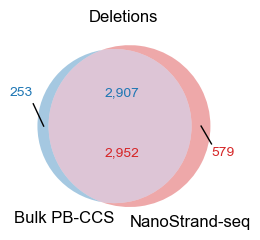

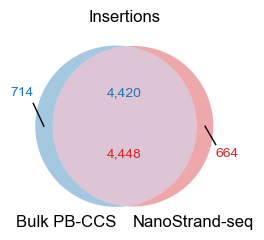

In [24]:
data = json.load(open("results/benchmark_of_HG001/PacBio.full_vs_HG001_Cell_350.json"))
d1, d2 = data["Del_Detail"]
n1, n2 = d1["Reference"], d1["Reference_Hit"]
n3, n4 = d2["Reference"], d2["Reference_Hit"]
plt.figure(figsize=(2.8, 2.5))
plt.title("Deletions")
vs = [n1 - n2, n3 - n4, int((n2 + n4)/2)]
ret = venn2(vs, set_labels=["Bulk PB-CCS", "NanoStrand-seq"], set_colors=["C0", "C3"])
if False:
    ret.subset_labels[0].set_text(format(vs[0], ","))
    ret.subset_labels[1].set_text(format(vs[1], ","))
    ret.subset_labels[2].set_text("%s   \n\n   %s" % (format(n2, ","), format(n4, ",")))
    plt.plot([0.25, 0.4], [-0.05, 0], color="black", lw=1)
    plt.plot([-0.35, -0.2], [0, 0.05], color="black", lw=1)
else:
    ret.subset_labels[0].set_text(None)
    ret.subset_labels[1].set_text(None)
    ret.subset_labels[2].set_text(None)
    plt.text(-0.6, 0.2, "%s" % format(n1 - n2, ","), ha="right", color="C0")
    plt.text(0, 0.2, "%s" % format(n2, ","), ha="center", color="C0")
    plt.text(0.6, -0.2, "%s" % format(n3 - n4, ","), ha="left", color="C3")
    plt.text(0, -0.2, "%s" % format(n4, ","), ha="center", color="C3")
    plt.plot([-0.6, -0.53], [0.15, 0], color="black", lw=1)
    plt.plot([0.6, 0.53], [-0.12, 0], color="black", lw=1)
plt.tight_layout()
plt.savefig("figures/benchmark_sv.pb_vs_nss.del.pdf", dpi=300)

d1, d2 = data["Ins_Detail"]
n1, n2 = d1["Reference"], d1["Reference_Hit"]
n3, n4 = d2["Reference"], d2["Reference_Hit"]
plt.figure(figsize=(2.8, 2.5))
plt.title("Insertions")
vs = [n1 - n2, n3 - n4, int((n2 + n4)/2)]
ret = venn2(vs, set_labels=["Bulk PB-CCS", "NanoStrand-seq"], set_colors=["C0", "C3"])
if False:
    ret.subset_labels[0].set_text(format(vs[0], ","))
    ret.subset_labels[1].set_text(format(vs[1], ","))
    ret.subset_labels[2].set_text("%s   \n\n   %s" % (format(n2, ","), format(n4, ",")))
    plt.plot([0.25, 0.4], [-0.05, 0], color="black", lw=1)
    plt.plot([-0.35, -0.2], [0, 0.05], color="black", lw=1)
else:
    ret.subset_labels[0].set_text(None)
    ret.subset_labels[1].set_text(None)
    ret.subset_labels[2].set_text(None)
    plt.text(-0.6, 0.2, "%s" % format(n1 - n2, ","), ha="right", color="C0")
    plt.text(0, 0.2, "%s" % format(n2, ","), ha="center", color="C0")
    plt.text(0.6, -0.2, "%s" % format(n3 - n4, ","), ha="left", color="C3")
    plt.text(0, -0.2, "%s" % format(n4, ","), ha="center", color="C3")
    plt.plot([-0.6, -0.53], [0.15, 0], color="black", lw=1) 
    plt.plot([0.6, 0.53], [-0.12, 0], color="black", lw=1)
plt.tight_layout()
plt.savefig("figures/benchmark_sv.pb_vs_nss.ins.pdf", dpi=300)

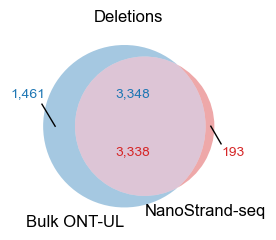

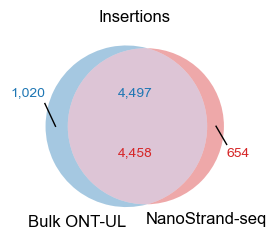

In [25]:
data = json.load(open("results/benchmark_of_HG001/Ultralong.full_vs_HG001_Cell_350.json"))
d1, d2 = data["Del_Detail"]
n1, n2 = d1["Reference"], d1["Reference_Hit"]
n3, n4 = d2["Reference"], d2["Reference_Hit"]
plt.figure(figsize=(2.8, 2.5))
plt.title("Deletions")
vs = [n1 - n2, n3 - n4, int((n2 + n4)/2)]
ret = venn2(vs, set_labels=["Bulk ONT-UL", "NanoStrand-seq"], set_colors=["C0", "C3"])
if False:
    ret.subset_labels[0].set_text(format(vs[0], ","))
    ret.subset_labels[1].set_text(format(vs[1], ","))
    ret.subset_labels[2].set_text("%s   \n\n   %s" % (format(n2, ","), format(n4, ",")))
    plt.plot([0.25, 0.4], [-0.05, 0], color="black", lw=1)
    plt.plot([-0.35, -0.2], [0, 0.05], color="black", lw=1)
else:
    ret.subset_labels[0].set_text(None)
    ret.subset_labels[1].set_text(None)
    ret.subset_labels[2].set_text(None)
    plt.text(-0.6, 0.2, "%s" % format(n1 - n2, ","), ha="right", color="C0")
    plt.text(0, 0.2, "%s" % format(n2, ","), ha="center", color="C0")
    plt.text(0.6, -0.2, "%s" % format(n3 - n4, ","), ha="left", color="C3")
    plt.text(0, -0.2, "%s" % format(n4, ","), ha="center", color="C3")
    plt.plot([-0.62, -0.53], [0.15, 0], color="black", lw=1)
    plt.plot([0.6, 0.53], [-0.12, 0], color="black", lw=1)
plt.tight_layout()
plt.savefig("figures/benchmark_sv.ont_vs_nss.del.pdf", dpi=300)

d1, d2 = data["Ins_Detail"]
n1, n2 = d1["Reference"], d1["Reference_Hit"]
n3, n4 = d2["Reference"], d2["Reference_Hit"]
plt.figure(figsize=(2.8, 2.5))
plt.title("Insertions")
vs = [n1 - n2, n3 - n4, int((n2 + n4)/2)]
ret = venn2(vs, set_labels=["Bulk ONT-UL", "NanoStrand-seq"], set_colors=["C0", "C3"])
if False:
    ret.subset_labels[0].set_text(format(vs[0], ","))
    ret.subset_labels[1].set_text(format(vs[1], ","))
    ret.subset_labels[2].set_text("%s   \n\n   %s" % (format(n2, ","), format(n4, ",")))
    plt.plot([0.25, 0.4], [-0.05, 0], color="black", lw=1)
    plt.plot([-0.35, -0.2], [0, 0.05], color="black", lw=1)
else:
    ret.subset_labels[0].set_text(None)
    ret.subset_labels[1].set_text(None)
    ret.subset_labels[2].set_text(None)
    plt.text(-0.6, 0.2, "%s" % format(n1 - n2, ","), ha="right", color="C0")
    plt.text(0, 0.2, "%s" % format(n2, ","), ha="center", color="C0")
    plt.text(0.6, -0.2, "%s" % format(n3 - n4, ","), ha="left", color="C3")
    plt.text(0, -0.2, "%s" % format(n4, ","), ha="center", color="C3")
    plt.plot([-0.6, -0.53], [0.15, 0], color="black", lw=1)
    plt.plot([0.6, 0.53], [-0.12, 0], color="black", lw=1)
plt.tight_layout()
plt.savefig("figures/benchmark_sv.ont_vs_nss.ins.pdf", dpi=300)

# Benchmark of SV for B6D2F1

## Benchmark regions

In [2]:
def worker(f_bw, chrom, step, min_coverage, max_coverage):
    regions = []
    f = pyBigWig.open(f_bw)
    length = f.chroms()[chrom]
    step1 = step * 1000
    for start1 in range(0, length, step1):
        end1 = min(start1 + step1, length)
        covs = f.values(chrom, start1, end1)
        for start2 in range(start1, end1, step):
            end2 = min(start2 + step, end1)
            vs = np.nan_to_num(covs[start2 - start1:end2 - start1])
            mean = np.mean(vs)
            if mean < min_coverage or mean > max_coverage:
                if len(regions) == 0:
                    regions.append([chrom, start2, end2])
                else:
                    if start2 <= regions[-1][2]:
                        regions[-1][2] = end2
                    else:
                        regions.append([chrom, start2, end2])
    f.close()            
    return regions


def scan_extreme_coverage_regions(f_bw, f_bed, threads=1, min_coverage=15, max_coverage=80):
    array = []
    pool = mp.Pool(threads)
    f = pyBigWig.open(f_bw)
    for chrom in f.chroms():
        args = (f_bw, chrom, 100, min_coverage, max_coverage)
        array.append(pool.apply_async(worker, args))
    f.close()
    pool.close()
    pool.join()

    regions = []
    for r in array:
        regions.extend(r.get())
    regions.sort()
    
    with open(f_bed, "w+") as fw:
        for r in regions:
            fw.write("\t".join(map(str, r)) + "\n")

def collapse_regions(regions):
    regions = regions.copy()
    i = 0
    while i < len(regions) - 1:
        r1 = regions[i]
        r2 = regions[i + 1]
        if r1[0] == r2[0]:
            if r1[2] >= r2[1]:
                r1[2] = max(r1[2], r2[2])
                regions.pop(i + 1)
            else:
                i += 1
        else:
            i += 1
    return regions

def scan_dense_sv_regions(f_vcf, f_bed, slop=1000):
    svs = []
    with pysam.VariantFile(f_vcf) as f:
        for record in f:
            svtype = record.info["SVTYPE"]
            if svtype != "DEL" and svtype != "INS":
                continue
            if list(record.filter)[0] != "PASS":
                continue
            r = GRange(chrom=record.contig, start=record.start, end=record.stop, name=record.id)
            r.length = abs(record.info["SVLEN"])
            r.record = record
            svs.append(r)
    svs.sort()
    
    regions = []
    loader = ShiftLoader(svs)
    for sv in svs:
        chrom, start, end = sv.chrom, max(0, sv.start - slop), sv.end + slop
        hit = False
        for sv2 in loader.fetch(chrom=chrom, start=start, end=end):
            if sv2 is not sv:
                hit = True
        if hit:
            regions.append([chrom, start, end])
    regions.sort()
    
    regions = collapse_regions(regions)
    
    with open(f_bed, "w+") as fw:
        for r in regions:
            fw.write("\t".join(map(str, r)) + "\n")

def scan_long_sv_regions(f_vcf, f_bed, max_length=10000, slop=1000):
    regions = []
    
    with pysam.VariantFile(f_vcf) as f:
        for record in f:
            svtype = record.info["SVTYPE"]
            if svtype != "DEL" and svtype != "INS":
                continue
            if list(record.filter)[0] != "PASS":
                continue
            if abs(record.info["SVLEN"]) > max_length:
                chrom = record.contig
                start = record.start
                end = record.stop
                start = max(0, start - slop)
                end = end + slop
                
                regions.append([chrom, start, end])
    regions.sort()
    
    regions = collapse_regions(regions)

    with open(f_bed, "w+") as fw:
        for r in regions:
            fw.write("\t".join(map(str, r)) + "\n")

In [6]:
! ls -lh ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/*

-rw-r--r-- 1 chenzg tfclab  53K Apr 10 01:24 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.coverage_lt_10_gt_80.bed
-rw-r--r-- 1 chenzg tfclab 299K Apr 10 01:26 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.coverage_lt_15_gt_80.bed
-rw-r--r-- 1 chenzg tfclab  34K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.dense_sv_1kb.bed
-rw-r--r-- 1 chenzg tfclab 1.9K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/PacBio.full.long_sv_10kb_slop_1kb.bed
-rw-r--r-- 1 chenzg tfclab  36K Apr 10 01:27 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/Ultralong.full.coverage_lt_10_gt_80.bed
-rw-r--r-- 1 chenzg tfclab  57K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/Ultralong.full.coverage_lt_15_gt_80.bed
-rw-r--r-- 1 chenzg tfclab  49K Apr 10 01:28 ../../3_NanoStrandSeq_PseudoBulk/results/sv/regions/Ultralong.full.dense_sv_1kb.bed
-rw-r--r-- 1 chenzg tfclab 2.8K Apr 10 01:29 ../../3_NanoStrandSeq_P

In [5]:
f_bw = "../../7_DBA_ONT_bulk/results/tracks/Bulk_WGS_ONT_DBA.bw"
f_bed = "results/benchmark_of_B6D2F1/DBA_WGS_ONT.coverage_lt_10_gt_80.bed"
scan_extreme_coverage_regions(f_bw, f_bed, 24, 10, 80)

In [9]:
f_bw = "../../7_DBA_ONT_bulk/results/tracks/Bulk_WGS_ONT_DBA.bw"
f_bed = "results/benchmark_of_B6D2F1/DBA_WGS_ONT.coverage_lt_15_gt_80.bed"
scan_extreme_coverage_regions(f_bw, f_bed, 24, 15, 80)

In [12]:
f_vcf = "../../7_DBA_ONT_bulk/results/sv/cutesv/Bulk_WGS_ONT_DBA.vcf.gz"
f_bed = "results/benchmark_of_B6D2F1/DBA_WGS_ONT.dense_sv_1kb.bed"
scan_dense_sv_regions(f_vcf, f_bed, 1000)

In [13]:
f_vcf = "../../7_DBA_ONT_bulk/results/sv/cutesv/Bulk_WGS_ONT_DBA.vcf.gz"
f_bed = "results/benchmark_of_B6D2F1/DBA_WGS_ONT.long_sv_10kb_slop_1kb.bed"
scan_long_sv_regions(f_vcf, f_bed, max_length=10000, slop=1000)

In [14]:
regions = []

with open("results/benchmark_of_B6D2F1/DBA_WGS_ONT.coverage_lt_10_gt_80.bed") as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")
        start, end = int(start), int(end)
        start, end = max(0, start - 1000), end + 1000
        regions.append([chrom, start, end])
        
with open("results/benchmark_of_B6D2F1/DBA_WGS_ONT.dense_sv_1kb.bed") as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")
        start, end = int(start), int(end)
        regions.append([chrom, start, end])
        
with open("results/benchmark_of_B6D2F1/DBA_WGS_ONT.long_sv_10kb_slop_1kb.bed") as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")
        start, end = int(start), int(end)
        regions.append([chrom, start, end])
    
regions.sort()
print("All regions:", len(regions))

regions = collapse_regions(regions)
print("Collapsed regions:", len(regions))

regions.sort()

All regions: 24382
Collapsed regions: 15733


In [15]:
with open("results/benchmark_of_B6D2F1/DBA_WGS_ONT.benchmark_blacklist.bed", "w+") as fw:
    for r in regions:
        fw.write("\t".join(map(str, r)) + "\n")

## Benchmark of SV

In [8]:
f_blacklist = "../../4_NanoStrandSeq_Phasing/results/Mouse_Cell_200/blackhole/blacklist.bed.gz"
with BedFile(f_blacklist) as f:
    blacklist = [x for x in f]
print(len(blacklist))

3235


In [9]:
f_blacklist = "results/benchmark_of_B6D2F1/DBA_WGS_ONT.benchmark_blacklist.bed"
with BedFile(f_blacklist) as f:
    blacklist = [x for x in f]
print(len(blacklist))

15733


In [20]:
def load_svs(path):
    dat = pd.read_csv(path, sep="\t")
    dat = dat[[re.match("^chr([0-9]+|[X])$", chrom) is not None for chrom in dat["Chrom"]]]
    dat = dat[dat["AgreeRead"] >= 3]
    dat = dat[dat["AgreeRead"] > (dat["DisagreeRead"] * 0.25)]
    
    svs = []
    for chrom, start, end, name, length in dat[["Chrom", "Start", "End", "Name", "Length"]].values:
        obj = GRange(chrom=chrom, start=start, end=end, name=name)
        obj.svlen = length
        svs.append(obj)
    svs.sort()
    loader = ShiftLoader(blacklist)
    svs1 = []
    for sv in svs:
        n = len(list(loader.fetch(obj=sv)))
        if n == 0:
            svs1.append(sv)

    flags = [True] * len(svs1)
    loader = ShiftLoader(svs1)
    for i, sv in enumerate(svs1):
        n = len(list(loader.fetch(chrom=sv.chrom, start=sv.start - 500, end=sv.end + 500)))
        if n > 1:
            flags[i] = False
    svs2 = []
    for flag, sv in zip(flags, svs1):
        if flag:
            svs2.append(sv)
    return svs2

def overlap_sv(svs1, svs2):
    n = 0
    loader = ShiftLoader(svs2)
    for sv in svs1:
        hit = False
        for sv2 in loader.fetch(chrom=sv.chrom, start=sv.start - 1000, end=sv.end + 1000):
            vmin = min(sv.svlen, sv2.svlen)
            vmax = max(sv.svlen, sv2.svlen)
            if vmin > vmax * 0.7:
                hit = True
        if hit:
            n += 1
    return n

del_ins_svs1 = load_svs("../../7_DBA_ONT_bulk/results/sv/quantify/Bulk_WGS_ONT_DBA_lite.tsv")
del_ins_svs2 = load_svs("../../4_NanoStrandSeq_Phasing/results/Mouse_Cell_200/sv/quantify_merged_lite.tsv")

Recall: 0.6744250815628232
Precision: 0.9213660340420904
Recall: 0.6432255392839664
Precision: 0.8869276295296439


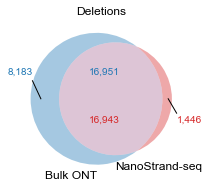

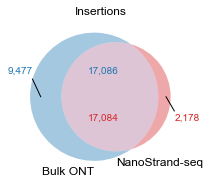

In [21]:
s1 = "DBA_ONT_bulk"
s2 = "NanoStrand-seq"
for t in ["DEL", "INS"]:
    svs1 = list(filter(lambda sv: t in sv.name, del_ins_svs1))
    svs2 = list(filter(lambda sv: t in sv.name, del_ins_svs2))
    n1 = len(svs1)
    n2 = overlap_sv(svs1, svs2)
    n3 = len(svs2)
    n4 = overlap_sv(svs2, svs1)
    print("Recall:", n2 / n1)
    print("Precision:", n4 / n3)

    plt.figure(figsize=(3, 3))
    if t == "DEL":
        plt.title("Deletions")
    else:
        plt.title("Insertions")
    vs = [n1 - n2, n3 - n4, int((n2 + n4)/2)]
    ret = venn2(vs, set_labels=["Bulk ONT", "NanoStrand-seq"], set_colors=["C0", "C3"])
    if False:
        ret.subset_labels[0].set_text(format(vs[0], ","))
        ret.subset_labels[1].set_text(format(vs[1], ","))
        ret.subset_labels[2].set_text("%s   \n\n   %s" % (format(n2, ","), format(n4, ",")))
        plt.plot([0.25, 0.4], [-0.05, 0], color="black", lw=1)
        plt.plot([-0.35, -0.2], [0, 0.05], color="black", lw=1)
    else:
        ret.subset_labels[0].set_text(None)
        ret.subset_labels[1].set_text(None)
        ret.subset_labels[2].set_text(None)
        plt.text(-0.6, 0.2, "%s" % format(n1 - n2, ","), ha="right", color="C0")
        plt.text(0, 0.2, "%s" % format(n2, ","), ha="center", color="C0")
        plt.text(0.6, -0.2, "%s" % format(n3 - n4, ","), ha="left", color="C3")
        plt.text(0, -0.2, "%s" % format(n4, ","), ha="center", color="C3")
        plt.plot([-0.6, -0.53], [0.15, 0], color="black", lw=1) 
        plt.plot([0.6, 0.53], [-0.12, 0], color="black", lw=1)
    
    plt.tight_layout()
    plt.savefig("figures/benchmark_sv_%s_%s_%s.pdf" % (s1, s2, t), dpi=300)